In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

<h1 align="center"> Gene Selection </h1>
<h3 align="center"> Christine Zhang </h3>

---

In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import pickle
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline

In [3]:
entrez_pd = pd.read_csv('../EntrezID.txt', skiprows = [0], sep ="\t", names = ["Hugo", "Symbol", "Entrez_ID"]) 
entrez = entrez_pd.as_matrix()
entrez_pd.head()

Hugo           Symbol  Entrez_ID
0      HGNC:5             A1BG        1.0
1  HGNC:37133         A1BG-AS1   503538.0
2  HGNC:24086             A1CF    29974.0
3      HGNC:6  A1S9T~withdrawn        NaN
4      HGNC:7              A2M        2.0

In [118]:
gene_lst_pd = pd.read_csv("gene_list.txt", names=["Genes"])
gene_lst = gene_lst_pd.as_matrix()
gene_lst_clean = [i for [i] in gene_lst]
print np.shape(gene_lst)
gene_lst_pd.head()

(118, 1)


Genes
0  CDKN2A-AS1
1      CDKN2A
2        PRKN
3     TP53BP1
4        AKT1

In [126]:
gene_entrez_id_lst = []
symbol_lst = list(entrez[:,1])
for gene in gene_lst:
    if gene in symbol_lst:
        gene_entrez_id_lst.append(entrez[symbol_lst.index(gene),2])
    else:
        gene_entrez_id_lst.append(-1)

In [127]:
gene_lst_pd["Entrez_id"] = gene_entrez_id_lst
gene_lst_pd.head()

Genes  Entrez_id
0  CDKN2A-AS1    51198.0
1      CDKN2A     1029.0
2        PRKN     5071.0
3     TP53BP1     7158.0
4        AKT1      207.0

### All Data

---

In [7]:
file_name = "auc_pd"
file_object = open(file_name,'r')  
auc_pd = pickle.load(file_object)
auc_pd.head()

Cclid Cellline                   Sites  Histology  \
0      3     5637           urinary_tract  carcinoma   
1      7    22RV1                prostate  carcinoma   
2     10   42MGBA  central_nervous_system     glioma   
3     15     647V           urinary_tract  carcinoma   
4     16     769P                  kidney  carcinoma   

                      Subhistology     Culture                    SNP    AUC  
0                               NS     RPMI001  SNP-matched-reference  2.473  
1                               NS     RPMI001  SNP-matched-reference  2.142  
2             astrocytoma_Grade_IV  RPMIMEM001  SNP-matched-reference  3.380  
3      transitional_cell_carcinoma     DMEM011  SNP-matched-reference  3.374  
4  clear_cell_renal_cell_carcinoma     RPMI001  SNP-matched-reference  3.123

In [8]:
file_name = "master_auc"
file_object = open(file_name,'r')  
master_auc_pd = pickle.load(file_object)
master_auc = master_auc_pd.as_matrix()
master_auc = master_auc.reshape([472,1])
print np.shape(master_auc)
master_auc_pd.head(n=10)

(472, 1)


3     2.473
7     2.142
10    3.380
15    3.374
16    3.123
19    3.779
21    3.471
22    2.625
23    4.677
25    2.751
Name: AUC, dtype: float64

In [85]:
file_name = "master_no_auc"
file_object = open(file_name,'r')  
master_no_auc_pd = pickle.load(file_object)
print np.shape(master_no_auc_pd)
master_no_auc_pd.head()

(472, 24704)


Entrez_id       1  503538   29974       2  144571  144568       3   53947  \
3         -0.0324 -0.0324 -0.4928 -0.0657 -0.0657 -0.0657 -0.0657 -0.0390   
7         -0.0762 -0.0762 -0.0025  0.4486  0.4486  0.4486  0.4486 -0.0574   
10         0.0346  0.0346 -0.0522 -0.3816 -0.3816 -0.3816 -0.3816 -0.0155   
15         0.2934  0.2934 -0.3050  0.1603  0.1603  0.1603  0.1603 -0.2881   
16         0.0463  0.0463  0.0436 -0.0112 -0.0112 -0.0112 -0.0112  0.0834   

Entrez_id   51146  100506677   ...    6608_y  8522_y  2885_y  2161_y  27255_y  \
3          0.0518     0.4291   ...       0.0     0.0     0.0     0.0      0.0   
7         -0.0303    -0.0712   ...       0.0     0.0     0.0     0.0      0.0   
10        -0.2675    -0.7758   ...       0.0     0.0     0.0     0.0      0.0   
15         0.2831     0.0613   ...       0.0     0.0     0.0     0.0      0.0   
16         0.0468     0.0528   ...       0.0     0.0     0.0     0.0      0.0   

Entrez_id  23072_y  6725_y  9149_y  6241_y  8301_y  
3              0.0     0.0     0.0     0.0     0.0  
7              0.0     0.0     0.0     0.0     0.0  
10             0.0     0.0     0.0     0.0     0.0  
15             0.0     0.0     0.0     0.0     0.0  
16             0.0     0.0     0.0     0.0     0.0  

[5 rows x 24704 columns]

In [86]:
# encode categorical variables
def encode_categorical(array):
    if not array.dtype == np.dtype('float64'):
        return preprocessing.LabelEncoder().fit_transform(array) 
    else:
        return array

# apply one hot encoding
def one_hot (dataframe): 
    sites_lst = []
    for index, val in enumerate(auc_pd["Cclid"]):
        if str(val) in list(dataframe.index):
            sites_lst.append(auc_pd.loc[index,"Sites"])
    dataframe.loc[:,"Sites"] = sites_lst
    
    # Categorical columns for use in one-hot encoder
    categorical = (dataframe.dtypes.values != np.dtype('float64'))

    # Encode all labels
    dataframe = dataframe.apply(encode_categorical)
    dataframe_np = dataframe.as_matrix()
    return dataframe_np, dataframe

# apply binary one hot encoding
def binary_one_hot (dataframe): 
    sites_lst = []
    for index, val in enumerate(auc_pd["Cclid"]):
        if str(val) in list(dataframe.index):
            sites_lst.append(auc_pd.loc[index,"Sites"])
    dataframe["Sites"] = sites_lst
    
    dataframe_binary_pd = pd.get_dummies(dataframe)
    dataframe_binary = dataframe_binary_pd.as_matrix()

    return dataframe_binary, dataframe_binary_pd

In [132]:
def select_columns(inttotest, dataframe):
    selected_pd = dataframe[[col for col in dataframe.columns if (str(col).startswith(str(inttotest)+"_") or str(col) == str(inttotest))]].head()
    return selected_pd.columns.values

full_column_lst = []
for each_int in gene_entrez_id_lst:
    selected_columns = select_columns(int(each_int), master_no_auc_pd)
    full_column_lst.append(selected_columns)   
full_column_lst = np.concatenate(full_column_lst)

In [133]:
master_no_auc_selected_pd = master_no_auc_pd.loc[:,master_no_auc_pd.columns.intersection(full_column_lst)]
master_no_auc_onehot, master_no_auc_onehot_pd = one_hot (master_no_auc_selected_pd)
master_no_auc_binary, master_no_auc_binary_pd = one_hot (master_no_auc_selected_pd)

In [73]:
linreg = LinearRegression()
svr_rbf = SVR(kernel = "rbf")
svr_lin = SVR(kernel = "linear")
rf = RandomForestRegressor()
lasso = linear_model.Lasso(alpha=0.1)
ridge = linear_model.Ridge(alpha=0.1)

# test naive models
def test_model (model):
    clf = model
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    r2 = clf.score(x_test, y_test)
    return y_pred, r2

def draw_plot (ax, y_pred, title, y_score):
    y_pred = y_pred.flatten()
    ax.scatter(y_pred, y_test)
    ax.plot(np.unique(y_pred), np.poly1d(np.polyfit(y_pred, y_test, 1))(np.unique(y_pred)))
    ax.set_title("%s r2 accuracy: %s" %(title, round(y_score, 3)))
    ax.set_xlabel("Predicted AUC")
    ax.set_ylabel("Actual AUC")
    return plt

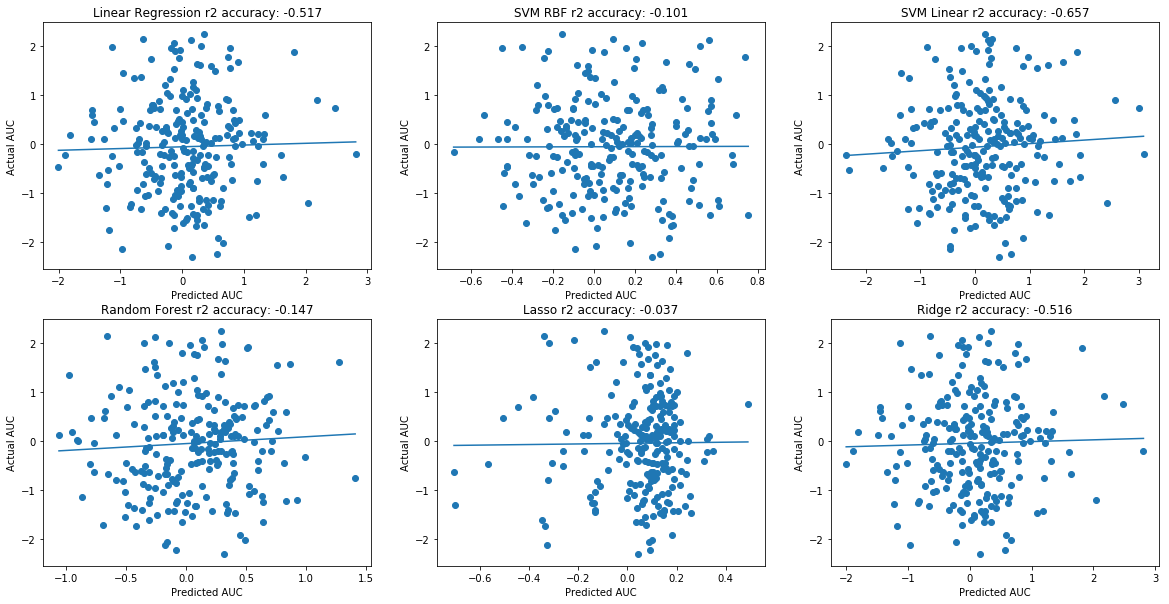

In [74]:
master_no_auc_selected_scaled = preprocessing.scale(master_no_auc_onehot)
master_auc_scaled = preprocessing.scale(master_auc)

x_train, x_test, y_train, y_test = train_test_split(master_no_auc_selected_scaled, master_auc_scaled, test_size=0.5, random_state=42)
y_test = y_test.flatten()
y_train = y_train.flatten()

# calculated r_2 values
linreg_y_pred, r2_linreg = test_model (linreg)
svr_rbf_y_pred, r2_svr_rbf = test_model (svr_rbf)
svr_lin_y_pred, r2_svr_lin = test_model (svr_lin)
rf_y_pred, r2_rf = test_model (rf)
y_pred_lasso, r2_lasso = test_model (lasso)
y_pred_ridge, r2_ridge = test_model (ridge)

fig_all, ax = plt.subplots(2, 3, figsize=(20, 10))
ax[0,0] = draw_plot (ax[0,0], linreg_y_pred, "Linear Regression", r2_linreg)
ax[0,1] = draw_plot (ax[0,1], svr_rbf_y_pred, "SVM RBF", r2_svr_rbf)
ax[0,2] = draw_plot (ax[0,2], svr_lin_y_pred, "SVM Linear", r2_svr_lin)
ax[1,0] = draw_plot (ax[1,0], rf_y_pred, "Random Forest", r2_rf)
ax[1,1] = draw_plot (ax[1,1], y_pred_lasso, "Lasso", r2_lasso)
ax[1,2] = draw_plot (ax[1,2], y_pred_ridge, "Ridge", r2_ridge)

In [75]:
master_no_auc_selected_scaled = preprocessing.scale(master_no_auc_binary)
master_auc_scaled = preprocessing.scale(master_auc)

x_train, x_test, y_train, y_test = train_test_split(master_no_auc_selected_scaled, master_auc_scaled, test_size=0.5, random_state=42)
y_test = y_test.flatten()
y_train = y_train.flatten()

# calculated r_2 values
linreg_y_pred_binary, r2_linreg_binary = test_model (linreg)
svr_rbf_y_pred_binary, r2_svr_rbf_binary = test_model (svr_rbf)
svr_lin_y_pred_binary, r2_svr_lin_binary = test_model (svr_lin)
rf_y_pred_binary, r2_rf_binary = test_model (rf)
y_pred_lasso_binary, r2_lasso_binary = test_model (lasso)
y_pred_ridge_binary, r2_ridge_binary = test_model (ridge)

fig_all, ax = plt.subplots(2, 3, figsize=(20, 10))
ax[0,0] = draw_plot (ax[0,0], linreg_y_pred_binary, "Linear Regression", r2_linreg_binary)
ax[0,1] = draw_plot (ax[0,1], svr_rbf_y_pred_binary, "SVM RBF", r2_svr_rbf_binary)
ax[0,2] = draw_plot (ax[0,2], svr_lin_y_pred_binary, "SVM Linear", r2_svr_lin_binary)
ax[1,0] = draw_plot (ax[1,0], rf_y_pred_binary, "Random Forest", r2_rf_binary)
ax[1,1] = draw_plot (ax[1,1], y_pred_lasso_binary, "Lasso", r2_lasso_binary)
ax[1,2] = draw_plot (ax[1,2], y_pred_ridge_binary, "Ridge", r2_ridge_binary)

### Just Mutation

---

In [15]:
file_name = "mutation_pd"
file_object = open(file_name,'r')  
mutation_pd = pickle.load(file_object)
mutation_pd.head()

Entrez_id  890     4478    2317    6790    120892  4342    4739    6498    \
3             0.0     0.0     0.0     0.0     1.0     0.0     0.0     0.0   
7             0.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0   
10            0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
15            0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
16            0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

Entrez_id  8313    10298    ...    6608    8522    2885    2161    27255   \
3             0.0     0.0   ...       0.0     0.0     0.0     0.0     0.0   
7             0.0     0.0   ...       0.0     0.0     0.0     0.0     0.0   
10            0.0     0.0   ...       0.0     0.0     0.0     0.0     0.0   
15            0.0     0.0   ...       0.0     0.0     0.0     0.0     0.0   
16            0.0     0.0   ...       0.0     0.0     0.0     0.0     0.0   

Entrez_id  23072   6725    9149    6241    8301    
3             0.0     0.0     0.0     0.0     0.0  
7             0.0     0.0     0.0     0.0     0.0  
10            0.0     0.0     0.0     0.0     0.0  
15            0.0     0.0     0.0     0.0     0.0  
16            0.0     0.0     0.0     0.0     0.0  

[5 rows x 1530 columns]

In [16]:
mutation_selected_pd = mutation_pd.loc[:,mutation_pd.columns.intersection(entrez_id_lst)]
mutation_onehot, mutation_onehot_pd = one_hot (mutation_selected_pd)
mutation_binary, mutation_binary_pd = one_hot (mutation_selected_pd)

In [17]:
just_mutation_scaled = preprocessing.scale(mutation_onehot_pd)

x_train, x_test, y_train, y_test = train_test_split(just_mutation_scaled, master_auc_scaled, test_size=0.5, random_state=42)
y_test = y_test.flatten()
y_train = y_train.flatten()

# calculated r_2 values
linreg_y_pred_mut, r2_linreg_mut = test_model (linreg)
svr_rbf_y_pred_mut, r2_svr_rbf_mut = test_model (svr_rbf)
svr_lin_y_pred_mut, r2_svr_lin_mut = test_model (svr_lin)
rf_y_pred_mut, r2_rf_mut = test_model (rf)
y_pred_lasso_mut, r2_lasso_mut = test_model (lasso)
y_pred_ridge_mut, r2_ridge_mut = test_model (ridge)

fig_all, ax = plt.subplots(2, 3, figsize=(20, 10))
ax[0,0] = draw_plot (ax[0,0], linreg_y_pred_mut, "Linear Regression", r2_linreg_mut)
ax[0,1] = draw_plot (ax[0,1], svr_rbf_y_pred_mut, "SVM RBF", r2_svr_rbf_mut)
ax[0,2] = draw_plot (ax[0,2], svr_lin_y_pred_mut, "SVM Lin", r2_svr_lin_mut)
ax[1,0] = draw_plot (ax[1,0], rf_y_pred_mut, "Random Forest", r2_rf_mut)
ax[1,1] = draw_plot (ax[1,1], y_pred_lasso_mut, "Lasso", r2_lasso_mut)
ax[1,2] = draw_plot (ax[1,2], y_pred_ridge_mut, "Ridge", r2_ridge_mut)

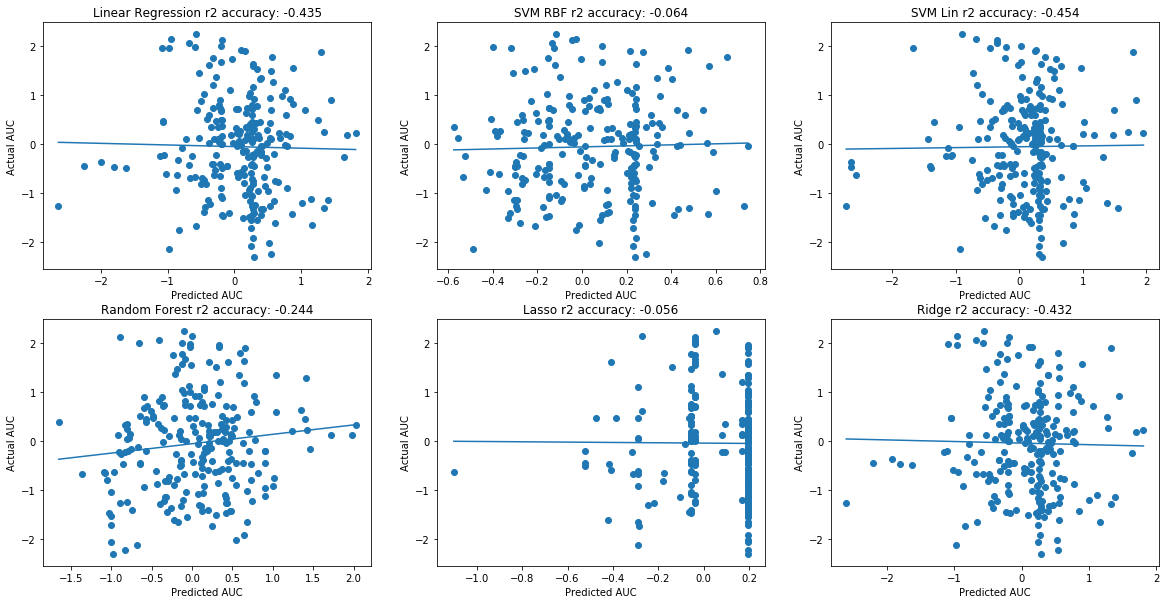

In [18]:
just_mutation_scaled = preprocessing.scale(mutation_binary_pd)

x_train, x_test, y_train, y_test = train_test_split(just_mutation_scaled, master_auc_scaled, test_size=0.5, random_state=42)
y_test = y_test.flatten()
y_train = y_train.flatten()

# calculated r_2 values
linreg_y_pred_mut_binary, r2_linreg_mut_binary = test_model (linreg)
svr_rbf_y_pred_mut_binary, r2_svr_rbf_mut_binary = test_model (svr_rbf)
svr_lin_y_pred_mut_binary, r2_svr_lin_mut_binary = test_model (svr_lin)
rf_y_pred_mut_binary, r2_rf_mut_binary = test_model (rf)
y_pred_lasso_mut_binary, r2_lasso_mut_binary = test_model (lasso)
y_pred_ridge_mut_binary, r2_ridge_mut_binary = test_model (ridge)

fig_all, ax = plt.subplots(2, 3, figsize=(20, 10))
ax[0,0] = draw_plot (ax[0,0], linreg_y_pred_mut_binary, "Linear Regression", r2_linreg_mut_binary)
ax[0,1] = draw_plot (ax[0,1], svr_rbf_y_pred_mut_binary, "SVM RBF", r2_svr_rbf_mut_binary)
ax[0,2] = draw_plot (ax[0,2], svr_lin_y_pred_mut_binary, "SVM Lin", r2_svr_lin_mut_binary)
ax[1,0] = draw_plot (ax[1,0], rf_y_pred_mut_binary, "Random Forest", r2_rf_mut_binary)
ax[1,1] = draw_plot (ax[1,1], y_pred_lasso_mut_binary, "Lasso", r2_lasso_mut_binary)
ax[1,2] = draw_plot (ax[1,2], y_pred_ridge_mut_binary, "Ridge", r2_ridge_mut_binary)

### Just Copy Number

---

In [19]:
file_name = "copynum_pd"
file_object = open(file_name,'r')  
copynum_clean_pd = pickle.load(file_object)
print np.shape(copynum_clean_pd)
copynum_pd = copynum_clean_pd

(472, 23174)


In [20]:
copynum_selected_pd = copynum_pd.loc[:,copynum_pd.columns.intersection(entrez_id_lst)]
cn_onehot, cn_onehot_pd = one_hot (copynum_selected_pd)
cn_binary, cn_binary_pd = one_hot (copynum_selected_pd)

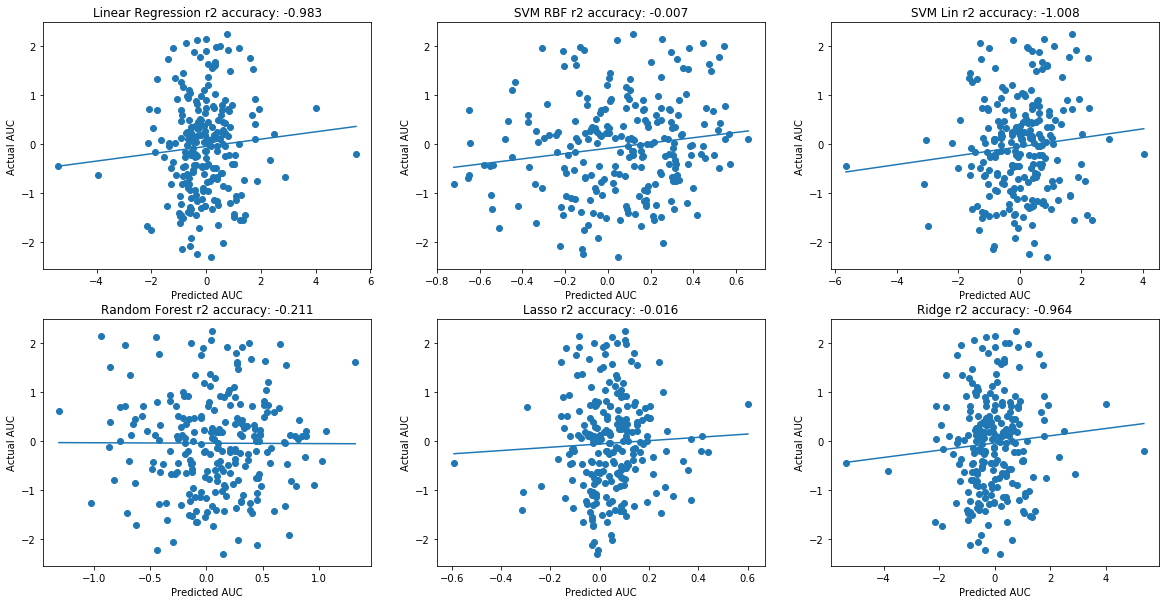

In [21]:
cn_scaled = preprocessing.scale(cn_onehot)

x_train, x_test, y_train, y_test = train_test_split(cn_scaled, master_auc_scaled, test_size=0.5, random_state=42)
y_test = y_test.flatten()
y_train = y_train.flatten()

# calculated r_2 values
linreg_y_pred_cn, r2_linreg_cn = test_model (linreg)
svr_rbf_y_pred_cn, r2_svr_rbf_cn = test_model (svr_rbf)
svr_lin_y_pred_cn, r2_svr_lin_cn = test_model (svr_lin)
rf_y_pred_cn, r2_rf_cn = test_model (rf)
y_pred_lasso_cn, r2_lasso_cn = test_model (lasso)
y_pred_ridge_cn, r2_ridge_cn = test_model (ridge)

fig_all, ax = plt.subplots(2, 3, figsize=(20, 10))
ax[0,0] = draw_plot (ax[0,0], linreg_y_pred_cn, "Linear Regression", r2_linreg_cn)
ax[0,1] = draw_plot (ax[0,1], svr_rbf_y_pred_cn, "SVM RBF", r2_svr_rbf_cn)
ax[0,2] = draw_plot (ax[0,2], svr_lin_y_pred_cn, "SVM Lin", r2_svr_lin_cn)
ax[1,0] = draw_plot (ax[1,0], rf_y_pred_cn, "Random Forest", r2_rf_cn)
ax[1,1] = draw_plot (ax[1,1], y_pred_lasso_cn, "Lasso", r2_lasso_cn)
ax[1,2] = draw_plot (ax[1,2], y_pred_ridge_cn, "Ridge", r2_ridge_cn)

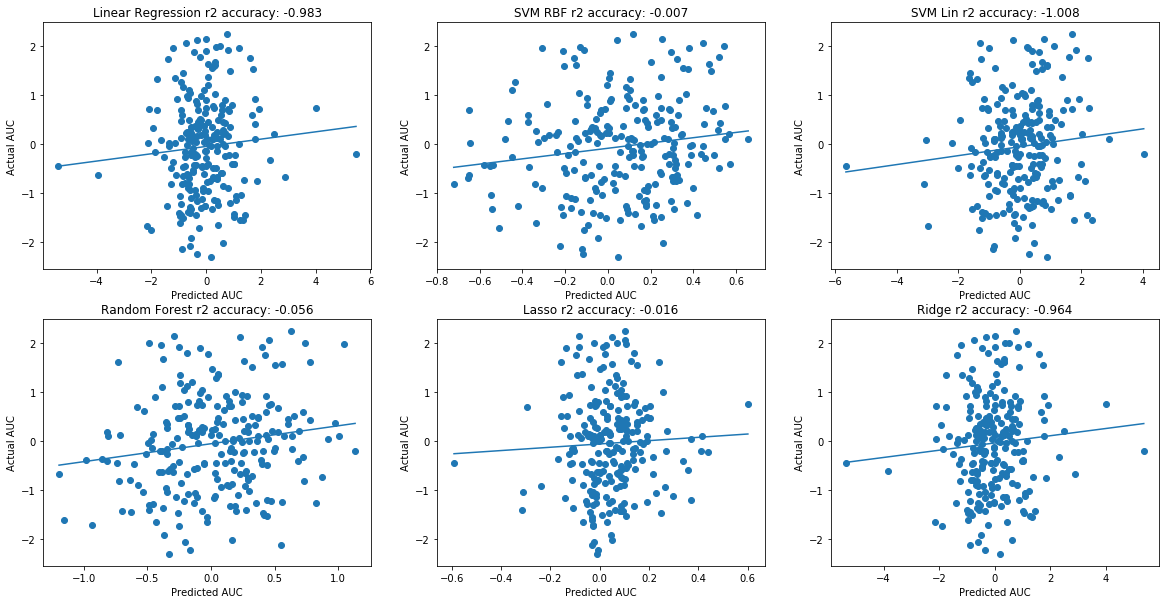

In [22]:
cn_scaled = preprocessing.scale(cn_binary)

x_train, x_test, y_train, y_test = train_test_split(cn_scaled, master_auc_scaled, test_size=0.5, random_state=42)
y_test = y_test.flatten()
y_train = y_train.flatten()

# calculated r_2 values
linreg_y_pred_cn_binary, r2_linreg_cn_binary = test_model (linreg)
svr_rbf_y_pred_cn_binary, r2_svr_rbf_cn_binary = test_model (svr_rbf)
svr_lin_y_pred_cn_binary, r2_svr_lin_cn_binary = test_model (svr_lin)
rf_y_pred_cn_binary, r2_rf_cn_binary = test_model (rf)
y_pred_lasso_cn_binary, r2_lasso_cn_binary = test_model (lasso)
y_pred_ridge_cn_binary, r2_ridge_cn_binary = test_model (ridge)

fig_all, ax = plt.subplots(2, 3, figsize=(20, 10))
ax[0,0] = draw_plot (ax[0,0], linreg_y_pred_cn_binary, "Linear Regression", r2_linreg_cn_binary)
ax[0,1] = draw_plot (ax[0,1], svr_rbf_y_pred_cn_binary, "SVM RBF", r2_svr_rbf_cn_binary)
ax[0,2] = draw_plot (ax[0,2], svr_lin_y_pred_cn_binary, "SVM Lin", r2_svr_lin_cn_binary)
ax[1,0] = draw_plot (ax[1,0], rf_y_pred_cn_binary, "Random Forest", r2_rf_cn_binary)
ax[1,1] = draw_plot (ax[1,1], y_pred_lasso_cn_binary, "Lasso", r2_lasso_cn_binary)
ax[1,2] = draw_plot (ax[1,2], y_pred_ridge_cn_binary, "Ridge", r2_ridge_cn_binary)

In [23]:
score_df = pd.DataFrame({'Linear Regression': [r2_linreg, r2_linreg_binary, r2_linreg_mut, r2_linreg_mut_binary, r2_linreg_cn, r2_linreg_cn_binary],
                         'SVM RBF': [r2_svr_rbf, r2_svr_rbf_binary, r2_svr_rbf_mut, r2_svr_rbf_mut_binary, r2_svr_rbf_cn, r2_svr_rbf_cn_binary],
                         'SVM Linear': [r2_svr_lin, r2_svr_lin_binary, r2_svr_lin_mut, r2_svr_lin_mut_binary, r2_svr_lin_cn, r2_svr_lin_cn_binary],
                         'Random Forest': [r2_rf, r2_rf_binary, r2_rf_mut, r2_rf_mut_binary, r2_rf_cn, r2_rf_cn_binary],
                         'Lasso': [r2_lasso, r2_lasso_binary, r2_lasso_mut, r2_lasso_mut_binary, r2_lasso_cn, r2_lasso_cn_binary],
                         'Ridge': [r2_ridge, r2_ridge_binary, r2_ridge_mut, r2_ridge_mut_binary, r2_ridge_cn, r2_ridge_cn_binary]}, 
                       index=["All", "All Binary", "Mutation Only","Mutation Binary", "Copy Number Only", "Copy Number Binary"])
score_df

Lasso  Linear Regression  Random Forest     Ridge  \
All                -0.011792          -0.041721      -0.137103 -0.041478   
All Binary         -0.011792          -0.041721      -0.017400 -0.041478   
Mutation Only      -0.055599          -0.435019      -0.253385 -0.432409   
Mutation Binary    -0.055599          -0.435019      -0.244497 -0.432409   
Copy Number Only   -0.015540          -0.982875      -0.211126 -0.963598   
Copy Number Binary -0.015540          -0.982875      -0.056455 -0.963598   

                    SVM Linear   SVM RBF  
All                  -0.179967 -0.019535  
All Binary           -0.179967 -0.019535  
Mutation Only        -0.454479 -0.064380  
Mutation Binary      -0.454479 -0.064380  
Copy Number Only     -1.007845 -0.006978  
Copy Number Binary   -1.007845 -0.006978

### With Gene Expression

---

In [43]:
file_name = "datasets/gene_exp_bin_pd"
file_object = open(file_name,'r')  
gene_exp_bin_pd = pickle.load(file_object)

In [42]:
gene_exp_pd = gene_exp_bin_pd.drop(gene_exp_bin_pd.loc[:,gene_exp_bin_pd.columns.str.contains("Sites")==True].columns, axis = 1)
gene_exp_pd.head()

100009676  10000      10001      10002      10003      100048912  \
3    5.979812   6.595651   9.663415   4.040661   4.159523   4.099417   
7    6.079415   4.521625   8.845639   3.768181   4.044822   4.151676   
10   5.373842   6.631749  10.001350   3.610522   4.242035   3.859894   
15   6.025009   7.510764   9.289334   3.685390   3.656942   4.138587   
16   5.444892   7.544216   8.715909   4.173643   3.663081   4.069507   

    10004      10005      10006      10007        ...      9989       \
3    4.518963   8.236260   8.543386  10.146590    ...      10.824800   
7    4.201540   7.922227   9.147535   8.564433    ...       8.963671   
10   4.561051   8.697279   8.833257   8.895942    ...      10.669690   
15   4.599801   8.492029   9.341341   9.578695    ...      10.812790   
16   4.523500   7.735855   9.247934  10.152180    ...       9.648020   

    998        9990       9991       9992       9993       9994       \
3    5.366379   6.102796   7.611540   4.590955   7.164869   7.092268   
7    5.304978   5.231049   8.704089   4.505268   6.679857   9.262698   
10   6.068712   5.735501   8.380994   4.505418   6.530644   8.844877   
15   5.128864   6.746001   8.342509   4.533303   6.942694   8.538819   
16   4.942413   5.591168   8.207547   4.719897   6.646730   8.307294   

    9997       999        9          
3    9.638273   8.372508   7.915253  
7   10.335640   9.852547  10.535870  
10   9.305898   4.312173   8.105601  
15   8.043184  11.278580   8.478392  
16   9.801101   4.339788   8.283828  

[5 rows x 18543 columns]

In [45]:
def PCA_apply (dataframe):
    dataframe = dataframe.transpose()
    master_cclid = dataframe.as_matrix()
    pca = PCA(n_components=20)
    scaled_data = preprocessing.scale(master_cclid)
    pca.fit(scaled_data)    
    pca.transform(scaled_data)
    pca_components_pd = pd.DataFrame(data = pca.components_, columns = dataframe.columns.values).transpose()
    pca_components = pca_components_pd.as_matrix()
    print "Amount of Variance explained by each component: ", pca.explained_variance_ratio_
    print "Total Variance Captured", np.sum(pca.explained_variance_ratio_)
    return pca_components

gene_exp_components = PCA_apply(gene_exp_pd)

Amount of Variance explained by each component:  [ 0.8750092   0.01464005  0.00755835  0.00399892  0.00353293  0.00311883
  0.00270719  0.00240871  0.00209823  0.00191912  0.0016035   0.00150193
  0.00139     0.00122414  0.00112369  0.00109075  0.00102634  0.00098758
  0.00095799  0.00090054]
Total Variance Captured 0.928797990921


In [135]:
master_no_auc_selected_pd = master_no_auc_selected_pd.drop("Sites", axis = 1)
master_no_auc_selected_clean_pd = master_no_auc_selected_pd.drop("895")
entrez_id_lst = master_no_auc_selected_clean_pd.index
master_no_auc_selected_clean_pd.head()

Entrez_id   51198  1029_x  1029_y    5071  7158_x  7158_y   207_x  207_y  \
3          0.3753  0.3753     0.0  0.0629 -0.0074     0.0 -0.0125    0.0   
7         -0.0383 -0.0383     0.0 -1.1599 -0.0705     1.0 -0.0806    0.0   
10        -2.7112 -2.7112     0.0 -4.5481  0.1218     0.0 -0.1531    0.0   
15        -0.2346 -0.2346     0.0 -0.3391 -0.2767     0.0 -0.3490    0.0   
16        -0.8478 -0.8478     0.0  0.0517  0.0557     0.0 -0.8636    0.0   

Entrez_id   472_x  472_y   ...    5291_y  3265_x  3265_y  3845_x  3845_y  \
3          0.0125    0.0   ...       0.0  0.3525     0.0  0.0012     0.0   
7         -0.0760    0.0   ...       0.0 -0.0453     0.0  0.4751     0.0   
10         0.3264    0.0   ...       0.0 -0.1469     0.0 -0.3030     0.0   
15         0.3385    0.0   ...       0.0  0.2474     0.0  0.2892     0.0   
16        -0.8866    0.0   ...       0.0  0.1084     0.0  0.0269     0.0   

Entrez_id  4893_x  4893_y   142_x  142_y   10038  
3          0.0792     0.0  0.0647    0.0 -0.0170  
7         -0.0492     0.0  0.5002    0.0 -0.0268  
10         0.5844     0.0 -0.2856    0.0  0.3687  
15         0.3228     0.0  0.3262    0.0 -0.3164  
16         0.0555     0.0  0.5440    0.0 -0.8966  

[5 rows x 182 columns]

In [136]:
auc_lst = []
for index, cclid in enumerate(auc_pd["Cclid"]):
    if str(cclid) in entrez_id_lst:
        auc_lst.append(auc_pd["AUC"][index])
auc_lst = np.array(auc_lst)
auc_lst = auc_lst.reshape([471,1])
print np.shape(auc_lst)

(471, 1)


In [138]:
gene_exp_components_trans = gene_exp_components.transpose()
for index, each in enumerate(gene_exp_components_trans):
    master_no_auc_selected_clean_pd["PCA_" + str(index)] = each
master_no_auc_selected_clean = master_no_auc_selected_clean_pd.as_matrix()
master_no_auc_selected_clean_pd.head()

Entrez_id   51198  1029_x  1029_y    5071  7158_x  7158_y   207_x  207_y  \
3          0.3753  0.3753     0.0  0.0629 -0.0074     0.0 -0.0125    0.0   
7         -0.0383 -0.0383     0.0 -1.1599 -0.0705     1.0 -0.0806    0.0   
10        -2.7112 -2.7112     0.0 -4.5481  0.1218     0.0 -0.1531    0.0   
15        -0.2346 -0.2346     0.0 -0.3391 -0.2767     0.0 -0.3490    0.0   
16        -0.8478 -0.8478     0.0  0.0517  0.0557     0.0 -0.8636    0.0   

Entrez_id   472_x  472_y    ...       PCA_10    PCA_11    PCA_12    PCA_13  \
3          0.0125    0.0    ...     0.062583  0.122099 -0.079704 -0.005844   
7         -0.0760    0.0    ...    -0.051373  0.000720 -0.014467  0.052003   
10         0.3264    0.0    ...    -0.018462  0.026849  0.021365  0.024778   
15         0.3385    0.0    ...     0.000770  0.078014 -0.004941 -0.060559   
16        -0.8866    0.0    ...    -0.103900  0.040933 -0.084560 -0.029491   

Entrez_id    PCA_14    PCA_15    PCA_16    PCA_17    PCA_18    PCA_19  
3         -0.008811  0.022196 -0.024909  0.015722 -0.001089 -0.031824  
7          0.005065  0.019283 -0.022097  0.043581 -0.025846  0.035123  
10         0.025550 -0.012521 -0.012441 -0.004421 -0.068264  0.001107  
15        -0.056001  0.007701  0.014225 -0.030591 -0.043450  0.031049  
16         0.005550 -0.086027  0.038829  0.033118  0.038082 -0.063851  

[5 rows x 202 columns]

In [139]:
selection_scaled = preprocessing.scale(master_no_auc_selected_clean)
auc_scaled = preprocessing.scale(auc_lst)

x_train, x_test, y_train, y_test = train_test_split(selection_scaled, auc_scaled, test_size=0.5, random_state=42)
y_test = y_test.flatten()
y_train = y_train.flatten()

# calculated r_2 values
linreg_y_pred_cn, r2_linreg_cn = test_model (linreg)
svr_rbf_y_pred_cn, r2_svr_rbf_cn = test_model (svr_rbf)
svr_lin_y_pred_cn, r2_svr_lin_cn = test_model (svr_lin)
rf_y_pred_cn, r2_rf_cn = test_model (rf)
y_pred_lasso_cn, r2_lasso_cn = test_model (lasso)
y_pred_ridge_cn, r2_ridge_cn = test_model (ridge)

fig_all, ax = plt.subplots(2, 3, figsize=(20, 10))
ax[0,0] = draw_plot (ax[0,0], linreg_y_pred_cn, "Linear Regression", r2_linreg_cn)
ax[0,1] = draw_plot (ax[0,1], svr_rbf_y_pred_cn, "SVM RBF", r2_svr_rbf_cn)
ax[0,2] = draw_plot (ax[0,2], svr_lin_y_pred_cn, "SVM Lin", r2_svr_lin_cn)
ax[1,0] = draw_plot (ax[1,0], rf_y_pred_cn, "Random Forest", r2_rf_cn)
ax[1,1] = draw_plot (ax[1,1], y_pred_lasso_cn, "Lasso", r2_lasso_cn)
ax[1,2] = draw_plot (ax[1,2], y_pred_ridge_cn, "Ridge", r2_ridge_cn)